In [1]:
import random

# StringIO behaves like a file object 
from io import StringIO 

from pandas import DataFrame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import load_boston
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sb

import copy

import joblib

%matplotlib inline 

In [2]:

print(joblib.__file__)

/Users/jonatasilva/Documents/ProjetosPython/python/venv37/lib/python3.7/site-packages/joblib/__init__.py


In [3]:
class CqkProblem:
    def __init__(self, r, n, d, a, b, low, up):
        self.n = n
        self.r = r
        self.d = list(d)
        self.a = list(a)
        self.b = list(b)
        self.low = list(low)
        self.up = list(up)

In [4]:
def generate_cqk_problem_uncorrelated(n):
    d = []
    low = []
    up = []
    b = []
    a = []
    temp = 0
    lb = 0.0
    ub = 0.0
    lower = 10
    upper = 25
    r = 0

    for i in range(n):
        
        b.append(10 + 14*random.random())
        low.append(1 + 14*random.random())
        up.append(1 + 14*random.random())
        if low[i] > up[i]:
            temp = low[i]
            low[i] = up[i]
            up[i] = temp
        
        lb = lb + b[i]*low[i];
        ub = ub + b[i]*up[i];
        
        #Uncorrelated
        d.append(random.randint(10,25))
        a.append(random.randint(10,25))
        
    r = lb + (ub - lb)*0.7;
    
    return CqkProblem( r, n, d, a, b, low, up)

def generate_cqk_problem_correlated(n):
    d = []
    low = []
    up = []
    b = []
    a = []
    temp = 0
    lb = 0.0
    ub = 0.0
    lower = 10
    upper = 25
    r = 0

    for i in range(n):
        
        b.append(10 + 14*random.random())
        low.append(1 + 14*random.random())
        up.append(1 + 14*random.random())
        if low[i] > up[i]:
            temp = low[i]
            low[i] = up[i]
            up[i] = temp
        
        lb = lb + b[i]*low[i];
        ub = ub + b[i]*up[i];
        
        # correlated:
        
        d.append(b[i] + 5.0)
        a.append(b[i] + 5.0)
        
        
        
    r = lb + (ub - lb)*0.7;
    
    return CqkProblem( r, n, d, a, b, low, up)

In [5]:

def initial_lambda(p, lamb):
    s0=0.0
    q0=0.0
    slopes = []
    for i in range(p.n):
        slopes.append((p.b[i]/p.d[i])*p.b[i])
        s0 = s0 + (p.a[i] * p.b[i]) / p.d[i]
        q0 = q0 + (p.b[i] * p.b[i]) / p.d[i]
    lamb = (p.r-s0)/q0
    return lamb, slopes

In [6]:
def phi_lambda(p,lamb,phi,deriv,slopes,r):
    deriv = 0.0
    phi = r * -1
    x = []
    
    for i in range(p.n):
        
        x.append( (p.b[i] * lamb + p.a[i])/p.d[i])

        if x[i] < p.low[i]:
            x[i] = p.low[i]
        elif x[i] > p.up[i]:
            x[i] = p.up[i]
        else:
            deriv = deriv + slopes[i];
        phi = phi + p.b[i] * x[i];
    return deriv, phi, x

In [7]:
MAX_IT = 20
INFINITO_NEGATIVO = -999999999;
INFINITO_POSITIVO = 999999999;

def newton(p):
    lambs = [] 
    phis = []
    derivs = []
    phi = 0
    lamb = 0
    alfa = INFINITO_NEGATIVO;
    beta = INFINITO_POSITIVO;
    phi_alfa = 0.0;
    phi_beta = 0.0;
    deriv = 0
    x = []
    r = p.r
    
    lamb, slopes = initial_lambda(p,lamb)
    deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
    lambs.append(lamb)
    derivs.append(deriv)
    phis.append(phi)
    it = 1
#     print(it, deriv, phi,lamb)
    negativo = False
    while phi != 0.0 and it <= MAX_IT:
        if phi > 0:
#             print("positivo")
            beta = lamb
            lambda_n = 0.0
            if deriv > 0.0:
                
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                if lambda_n > alfa:
                    lamb = lambda_n
                else:
#                     print("aqui")
                    phi_beta = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_left(p,lamb);
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
                
        else:
            if it == 1:
                negativo = True
#             print("negativo")
            alfa = lamb;
            lambda_n = 0.0;

            if deriv > 0.0:
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                
                if lambda_n < beta:
                    lamb = lambda_n
                else:
#                     print("aqui")
                    phi_alfa = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_right(p,lamb)
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
        
        
        deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
        it = it + 1
        lambs.append(lamb)
        derivs.append(deriv)
        phis.append(phi)
        
    if phi == 0.0:
        return it,lambs, derivs, phis,slopes
    elif alfa == beta:
        return -1,lambs, derivs, phis,slopes
    else:
        return -2,lambs, derivs, phis,slopes

In [8]:
MAX_IT = 20
INFINITO_NEGATIVO = -999999999;
INFINITO_POSITIVO = 999999999;

def newton_new_lamb(p,lamb,phi,deriv,slopes):
    lambs = [] 
    phis = []
    derivs = []
    alfa = INFINITO_NEGATIVO;
    beta = INFINITO_POSITIVO;
    phi_alfa = 0.0;
    phi_beta = 0.0;
    deriv = 0
    x = []
    r = p.r
    
    deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
    lambs.append(lamb)
    derivs.append(deriv)
    phis.append(phi)
    it = 1
#     print(it, deriv, phi,lamb)
    while phi != 0.0 and it <= MAX_IT:
        if phi > 0:
#             print("positivo")
            beta = lamb
            lambda_n = 0.0
            if deriv > 0.0:
                
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                if lambda_n > alfa:
                    lamb = lambda_n
                else:
#                     print("aqui")
                    phi_beta = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_left(p,lamb);
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
                
        else:
#             print("negativo")
            alfa = lamb;
            lambda_n = 0.0;

            if deriv > 0.0:
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                
                if lambda_n < beta:
                    lamb = lambda_n
                else:
#                     print("aqui")
                    phi_alfa = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_right(p,lamb)
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
        
        
        deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
        it = it + 1
        lambs.append(lamb)
        derivs.append(deriv)
        phis.append(phi)
        
    if phi == 0.0:
        return it,lambs, derivs, phis,slopes
    elif alfa == beta:
        return -1,lambs, derivs, phis,slopes
    else:
        return -2,lambs, derivs, phis,slopes

In [9]:
lista = []
for i in range(1):
    n = 10000
    p = generate_cqk_problem_correlated(n)
    it,lambs, derivs, phis,slopes = newton(p)
    soma_a = 0
    soma_b = 0
    soma_low = 0
    soma_d = 0
    soma_up = 0
    for i in range(n):
        soma_a += p.a[i]
        soma_b += p.b[i]
        soma_low += p.low[i]
        soma_d += p.d[i]
        soma_up += p.up[i]
    soma_a = soma_a/n
    soma_b = soma_b/n
    soma_low = soma_low/n
    soma_d = soma_d/n
    soma_up = soma_up/n
    r = p.r/n
    
    new_deriv = []
    new_phi = []
    new_lamb = []
    add_lamb = 5
    for i in range(3):
#         newLamb = lambs[i+1]+random.uniform(-0.1, 0.1)
        newLamb = add_lamb
        deriv, phi, x = phi_lambda(p,newLamb,0,0,slopes,p.r)
        new_deriv.append(deriv)
        new_phi.append(phi)
        new_lamb.append(newLamb)
        add_lamb += 2
        
    sum_slopes = sum(slopes)
    if it > 3:
        l_rs = [new_lamb[0],new_phi[0],new_deriv[0],new_lamb[1],new_phi[1],new_deriv[1],new_lamb[2],new_phi[2],new_deriv[2],lambs[-1]]


#         l_rs = [soma_a, soma_b, soma_d, r,lambs[0],phis[0],derivs[0],sum_slopes,lambs[1],phis[1],derivs[1],lambs[2],lambs[3],lambs[-1]]
#         l_rs = [soma_a, soma_b, soma_d, r,lambs[0],lambs[1],lambs[2],lambs[3],lambs[-1]]


        lista.append(l_rs)

In [10]:
np.savetxt('instance_test.txt', lista, delimiter = ' ',newline='\n', fmt="%f")

In [234]:
c = ''
with open("uncorrelated_8dot65_9_10k.txt", "r") as fd:
    c = StringIO(fd.read())
    
d = c.read()
c = StringIO(d) 
d = np.loadtxt(c) 
feature_names = ['8.8','9','final_lamb']
# feature_names = ['second_lamb','second_phi','second_deriv','third_lamb','third_phi','third_deriv','fourth_lamb','fourth_phi','fourth_deriv','final_lamb']
# 
# feature_names = ['a','b','d','r','inicital_lamb','second_lamb','third_lamb','fourth_lamb','final_lamb']


knapsack = {"data":d, "feature_names": feature_names}
dataset = pd.DataFrame(knapsack['data'], columns = knapsack['feature_names'])

In [241]:
# Coletando x e y

X = dataset.iloc[:,:-1]
y = dataset['final_lamb'].values

In [242]:
dataset

,8.8,9,final_lamb
0,998.939432,11516.765565,8.781304
1,433.817675,10788.134706,8.791802
2,-1274.833885,9360.533744,8.823496
3,1349.016643,12169.717208,8.775503
4,-2120.130726,8595.188800,8.839068
...,...,...,...
9995,3458.912349,13763.245923,8.734889
9996,-2379.431462,7966.956837,8.845568
9997,-7367.160706,3240.113655,8.938663
9998,-6796.679985,3974.820355,8.925512


In [243]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [245]:
# Padronização
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [246]:
# Aplicando a padronização aos dados
X_train_p = scaler.transform(X_train)
X_test_p = scaler.transform(X_test)

In [247]:
# joblib.dump(scaler, 'scaler_final_lamb.bin', compress=True)

In [248]:

# from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

In [272]:
# mlp = MLPClassifier(hidden_layer_sizes = (30,30,30))
regr = MLPRegressor(hidden_layer_sizes=(100,),activation='identity',random_state=1, max_iter=10000,
                    tol=1e-100, epsilon=1e-100,alpha=1e-100).fit(X_train_p, y_train)



In [273]:
# model = 'model_final_lamb.sav'
# joblib.dump(regr, model)

In [274]:
regr.fit(X_train_p, y_train)

MLPRegressor(activation='identity', alpha=1e-100, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-100,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='adam',
             tol=1e-100, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [275]:
regr.predict(X_test_p[:20])

array([8.91836261, 8.91992131, 8.80830725, 8.82249557, 8.84065973,
       8.81008627, 8.92376262, 8.86939933, 8.88516737, 8.78387318,
       8.80922976, 8.88403374, 8.87769505, 8.88955872, 8.99584875,
       8.91379096, 8.92303831, 8.81972319, 8.89794182, 8.82808251])

In [276]:
regr.score(X_test_p, y_test)

0.9997698018156511

In [277]:
y_test[:20]

array([8.917912, 8.920503, 8.808109, 8.82227 , 8.840487, 8.80983 ,
       8.925825, 8.86954 , 8.885374, 8.784202, 8.80832 , 8.884178,
       8.878104, 8.890569, 8.996152, 8.914208, 8.923754, 8.818915,
       8.897967, 8.828483])

In [278]:
def phi_lambda_two(p,lamb1,lamb2,r):
    
    slopes = []
    
    deriv2 = 0
    phi2 = r * -1
    
    deriv1 = 0
    phi1 = r * -1

    x2 = []
    x1 = []
    
    for i in range(p.n):
        
        slopes.append((p.b[i]/p.d[i])*p.b[i])
        
        x1.append( (p.b[i] * lamb1 + p.a[i])/p.d[i])

        if x1[i] < p.low[i]:
            x1[i] = p.low[i]
        elif x1[i] > p.up[i]:
            x1[i] = p.up[i]
        else:
            deriv1 = deriv1 + slopes[i];
        phi1 = phi1 + p.b[i] * x1[i];
        
#         ########
        
        x2.append( (p.b[i] * lamb2 + p.a[i])/p.d[i])

        if x2[i] < p.low[i]:
            x2[i] = p.low[i]
        elif x2[i] > p.up[i]:
            x2[i] = p.up[i]
        else:
            deriv2 = deriv2 + slopes[i];
        phi2 = phi2 + p.b[i] * x2[i];
        
        #########
        
#         x3.append( (p.b[i] * lamb3 + p.a[i])/p.d[i])

#         if x3[i] < p.low[i]:
#             x3[i] = p.low[i]
#         elif x3[i] > p.up[i]:
#             x3[i] = p.up[i]
#         else:
#             deriv3 = deriv3 + slopes[i];
#         phi3 = phi3 + p.b[i] * x3[i];

            
    return deriv1,phi1,deriv2,phi2,slopes

In [185]:
%%time
n = 100000
pp = generate_cqk_problem_uncorrelated(n)
itt,lambss, derivss, phiss,slopess = newton(pp)


CPU times: user 1.16 s, sys: 18.9 ms, total: 1.18 s
Wall time: 1.18 s


In [186]:
itt,lambss, phiss

(5,
 [7.079128137133873,
  8.64758357658087,
  8.846770538026858,
  8.85007127780266,
  8.85007233000119],
 [-1084716.902796639,
  -110189.02511160079,
  -1768.2848997277817,
  -0.5633393140714134,
  -8.684102681399963e-08])

In [187]:
%%time
deriv1, phi1,deriv2,phi2,slopess= phi_lambda_two(pp,8.65,9,pp.r)



result = regr.predict(scaler.transform(np.asarray([[phi1/10,phi2/10]])))[0]

itt,lambss, derivss, phiss,slopess = newton_new_lamb(pp,result,deriv1, phi1,slopess)


CPU times: user 744 ms, sys: 10.4 ms, total: 754 ms
Wall time: 757 ms


In [188]:
deriv1, phi1,deriv2,phi2,result

(540052.4456611348,
 -26916.86175528933,
 522337.8687502952,
 79293.86441992896,
 8.850185254414571)

In [189]:
lambss

[8.850185254414571, 8.850072330001243]

In [191]:
dataset['8.8'].corr(dataset['final_lamb'])

-0.9997968845512765

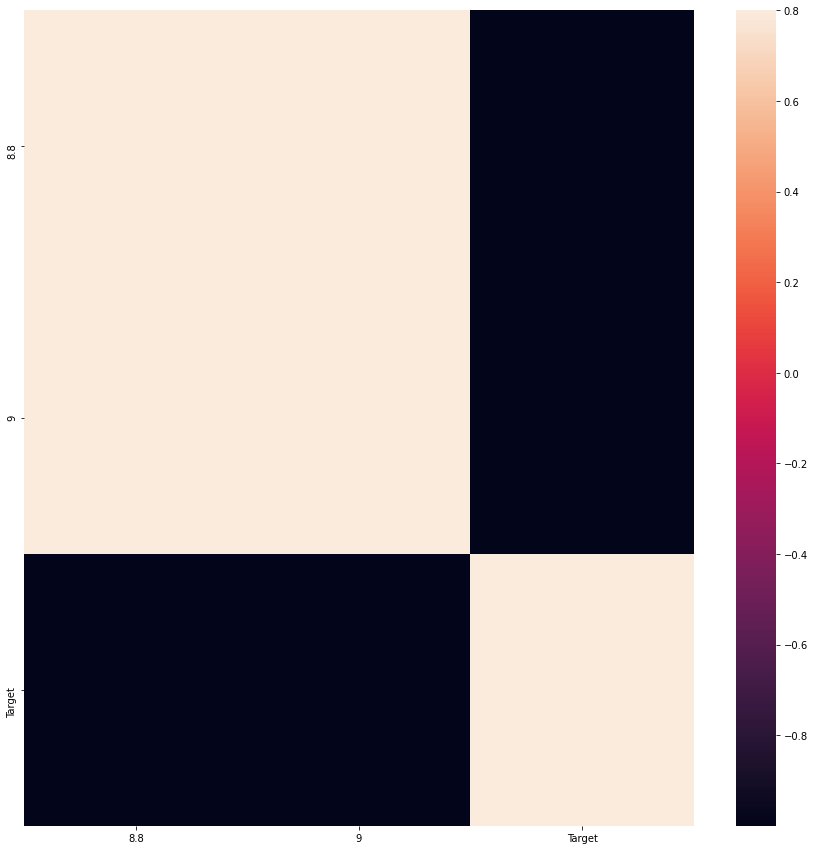

In [192]:
train_data = dataset.iloc[:,:-1]
train_data['Target'] = dataset['final_lamb']
# train_data = dataset[8]
# train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = False)
plt.show()

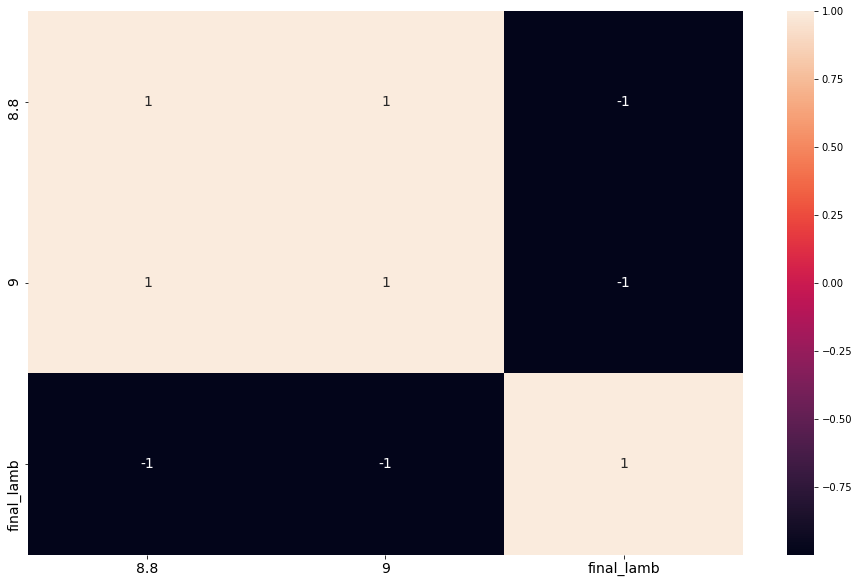

In [193]:
plt.figure(figsize=(16,10))
sb.heatmap(dataset.corr(), annot=True, annot_kws={"size":14})
# sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

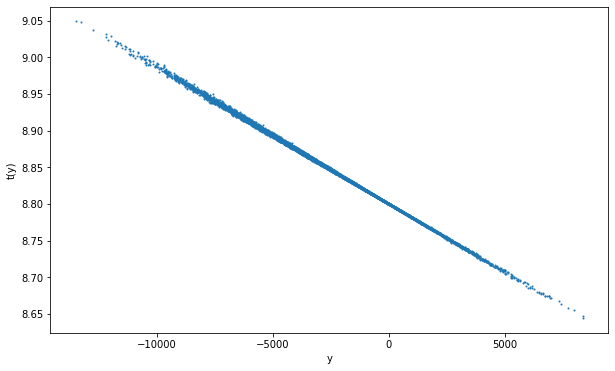

In [195]:
data = {'t': dataset['8.8'],
        'y': dataset['final_lamb'],
       }

df = pd.DataFrame (data, columns = ['t','y'])

Xx = DataFrame(data,columns=['t'])
yy = DataFrame(data,columns=['y'])

plt.figure(figsize=(10,6))
plt.scatter(Xx,yy,s=1)
plt.xlabel('y')
plt.ylabel('t(y)')
plt.show()

In [210]:
dataset

,8.8,9,final_lamb
0,998.939432,11516.765565,8.781304
1,433.817675,10788.134706,8.791802
2,-1274.833885,9360.533744,8.823496
3,1349.016643,12169.717208,8.775503
4,-2120.130726,8595.188800,8.839068
...,...,...,...
9995,3458.912349,13763.245923,8.734889
9996,-2379.431462,7966.956837,8.845568
9997,-7367.160706,3240.113655,8.938663
9998,-6796.679985,3974.820355,8.925512


In [211]:
from sklearn import linear_model

In [212]:
modelo = linear_model.LinearRegression(normalize = False, fit_intercept = True)

In [223]:
X_train

,8.8
6612,-4503.337392
3418,-3128.407894
3800,-5214.531697
2550,-2359.668885
4911,-2736.533906
...,...
125,-6771.544480
2683,-2390.499197
114,273.152985
7996,-6976.464518


In [225]:
# Define os valores de x e y
num_observ = len(X_train)
X = X_train['8.8'].values.reshape((num_observ, 1)) # X deve sempre ser uma matriz e nunca um vetor
y = y_train # y pode ser um vetor

In [226]:
# Aplica o modelo - fit()
modelo.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [227]:
# Imprime os coeficientes
print (modelo.coef_)
print (modelo.intercept_)

[-1.86894287e-05]
8.800023206638496


In [232]:
# Imprime as previsões

X_train, X_test, y_train, y_test

print (modelo.predict(X_test)[:10])

[8.94444812 8.90174749 8.84202032 8.82572719 8.88624282 8.80740456
 8.89122898 8.84421848 8.8718007  8.86789322]


In [231]:
y_test[:10]

array([8.946693, 8.899553, 8.842027, 8.826188, 8.884848, 8.807297,
       8.888021, 8.844302, 8.870469, 8.867642])

In [233]:
modelo.score(X, y)

0.9995957516156395

In [220]:
dataset

,8.8,9,final_lamb
0,998.939432,11516.765565,8.781304
1,433.817675,10788.134706,8.791802
2,-1274.833885,9360.533744,8.823496
3,1349.016643,12169.717208,8.775503
4,-2120.130726,8595.188800,8.839068
...,...,...,...
9995,3458.912349,13763.245923,8.734889
9996,-2379.431462,7966.956837,8.845568
9997,-7367.160706,3240.113655,8.938663
9998,-6796.679985,3974.820355,8.925512


In [157]:
final = 0
for index, row in dataset.iterrows():
    final += row['final_lamb']

In [160]:
final

88493.13098800003